In [17]:
import pandas as pd
import numpy as np
from scipy import stats as sp
import sys, os
sys.path.append('../')
from lib import trace_analysis
from lib import plots_analysis
from lib import trace_statistics
from lib import trace_classification
import csv
import warnings 
warnings.filterwarnings('ignore')

# Data Preparation


Prepare the data to be used with kNN

In [18]:
plots = set()
with open('traces/traces.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            line_count += 1
            continue
        else:
            plots.add((row[1], row[2]))

plots = list(plots) 

stats = None
win_25_stats = None
win_50_stats = None
win_100_stats = None

for row in plots:
    label = 'Normal'
    experiment = row[1]
    
    # Assign a label
    if row[1].find('gh') >= 0:
        label = 'Gray Hole'
    elif row[1].find('bh') >= 0:
        label = 'Black Hole'
    nodes, packets_node = trace_analysis.process_cooja2_traces(row[0], row[1])
    
    # Update stats
    if stats is None:
        stats = trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)
        win_25_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)
        win_50_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)
        win_100_stats = trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)
    else:
        stats = pd.concat([stats, trace_statistics.compute_labeled_statistics(nodes, packets_node, label, experiment)])
        win_25_stats = pd.concat([win_25_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 25)])
        win_50_stats = pd.concat([win_50_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 50)])
        win_100_stats = pd.concat([win_100_stats, trace_statistics.compute_window_labeled_statistics(nodes, packets_node, label, experiment, 100)])
        
stats = stats.reset_index(drop=True)
win_25_stats = win_25_stats.reset_index(drop=True)
win_50_stats = win_50_stats.reset_index(drop=True)
win_100_stats = win_100_stats.reset_index(drop=True)

# Create a dictionary containing all the statistics for each trace size
trace_stats = {200: stats, 25: win_25_stats, 50: win_50_stats, 100: win_100_stats}
stats.head(5)

,node_id,experiment,count,mean,var,std,hop,min,max,loss,outliers,label
0,aaaa::212:7409:9:909:,grid_1bh-9_2019-02-20_00:30_,158,306.278481,25524.902846,159.765149,3,163.0,1038.0,0.21,9,Black Hole
1,aaaa::212:740a:a:a0a:,grid_1bh-9_2019-02-20_00:30_,192,266.895833,6109.654014,78.164276,4,168.0,604.0,0.04,12,Black Hole
2,aaaa::212:7402:2:202:,grid_1bh-9_2019-02-20_00:30_,186,145.939247,5965.375370,77.235843,2,73.4,622.0,0.07,7,Black Hole
3,aaaa::212:7408:8:808:,grid_1bh-9_2019-02-20_00:30_,168,245.690476,24507.137154,156.547556,2,102.0,837.0,0.16,13,Black Hole
4,aaaa::212:7403:3:303:,grid_1bh-9_2019-02-20_00:30_,198,103.561616,5068.714255,71.194903,1,40.0,418.0,0.01,11,Black Hole


Stats for single network

In [19]:
net_stats = trace_statistics.compute_labeled_statistics_by_network(stats, 'loss', 16)
net_win_25_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_25_stats, 'loss', 16, 25)
net_win_50_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_50_stats, 'loss', 16, 50)
net_win_100_stats = trace_statistics.compute_window_labeled_statistics_by_network(win_100_stats, 'loss', 16, 100)

# Create a dictionary containing all the statistics for each trace size
network_stats = {200: net_stats, 25: net_win_25_stats, 50: net_win_50_stats, 100: net_win_100_stats}
net_stats.head(5)

,experiment,label,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,grid_1bh-7_2019-02-19_22:13_,Black Hole,0.100,0.275,0.255,0.220,0.200,0.240,0.170,0.190,0.215,0.240,0.230,0.305,0.170,0.080,9.223372e+18,9.223372e+18
1,grid_1bh-9_2019-02-20_00:30_,Black Hole,0.210,0.070,0.160,0.040,0.205,0.125,0.250,0.100,0.130,0.015,0.045,0.025,0.010,0.075,9.223372e+18,9.223372e+18
2,grid_1gh30-7_2019-02-19_22:35_,Gray Hole,0.550,0.695,0.885,0.380,0.425,0.890,0.335,0.705,0.455,0.475,0.350,0.480,0.235,0.705,8.250000e-01,6.350000e-01
3,grid_1gh30-9_2019-02-20_00:12_,Gray Hole,0.790,0.120,0.060,0.105,0.220,0.180,0.115,0.760,0.125,0.180,0.070,0.220,0.065,0.155,1.550000e-01,3.200000e-01
4,grid_1gh50-7_2019-02-19_22:53_,Gray Hole,0.165,0.270,0.650,0.625,0.580,0.145,0.300,0.160,0.315,0.170,0.300,0.170,0.205,0.350,3.600000e-01,3.450000e-01


# Feature Selection

Select the set of features and labels that we use to fit the algorithm

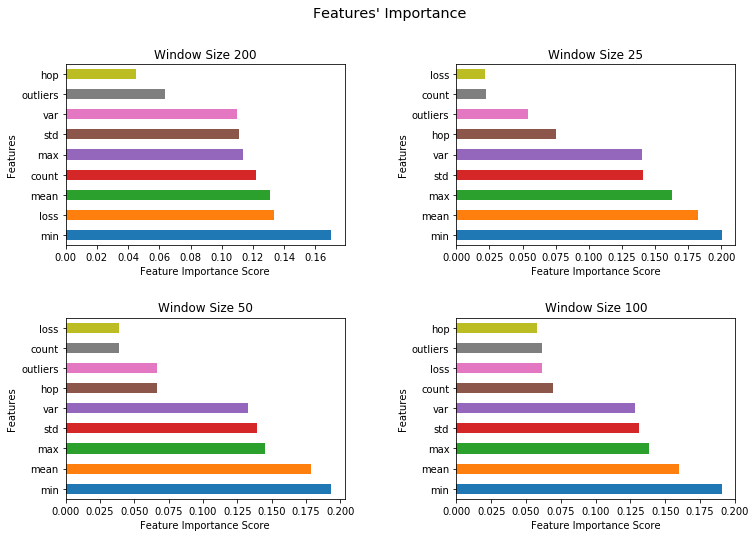

In [20]:
plots_analysis.random_forests_features_selection(trace_stats)

In [21]:
results = None            # Results from each classification algorithm
cv_results = None         # Cross validation results from each classification algorithm
net_results = None            # Results from each classification algorithm
cv_net_results = None         # Cross validation results from each classification algorithm

features_to_drop = ['node_id', 'experiment', 'label', 'loss', 'count', 'outliers']
net_features_to_drop = ['experiment', 'label']

# Random Forests Classifier

Let us experiment with random forests. First, let us select most relevant features.

In [22]:
results = pd.concat([results, 
                     trace_classification.random_forest_classification(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [23]:
cv_results = pd.concat([cv_results, 
                     trace_classification.random_forest_cross_validation(trace_stats, features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [24]:
net_results = pd.concat([net_results, 
                     trace_classification.random_forest_classification(network_stats, net_features_to_drop)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [25]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.random_forest_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# K-Nearest Neighbor (KNN) Classification

Let us first observe the accuracies for different values of k

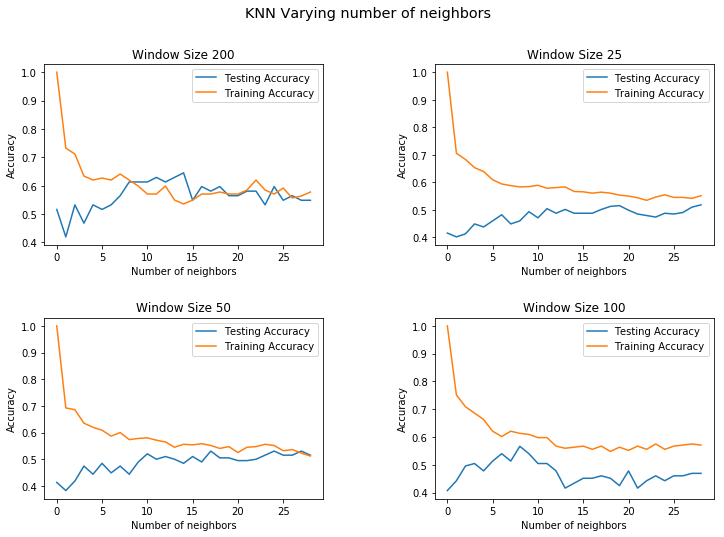

In [26]:
plots_analysis.knn_test_number_of_neighbors(trace_stats, 30)

Let's build KNN classifier 

In [27]:
results = pd.concat([results, 
                     trace_classification.k_nearest_neighbor_classification(trace_stats, features_to_drop, n_neighbors=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [28]:
cv_results = pd.concat([cv_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(trace_stats, features_to_drop, n_neighbors=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [29]:
net_results = pd.concat([net_results, 
                     trace_classification.k_nearest_neighbor_classification(network_stats, net_features_to_drop, n_neighbors=9)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [30]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.k_nearest_neighbor_cross_validation(network_stats, net_features_to_drop, n_neighbors=8, cross_val=3)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# Support Vector Machines (SVM) Classification

Let us experiment with another classifier

In [31]:
results = pd.concat([results, 
                     trace_classification.support_vector_machines_classification(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


We want to compute average accuracy for each trace size (i.e. for each window size from 200 - the entire window - to 100, 50 and 25)

In [32]:
cv_results = pd.concat([cv_results, 
                     trace_classification.support_vector_machines_cross_validation(trace_stats, features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [33]:
net_results = pd.concat([net_results, 
                     trace_classification.support_vector_machines_classification(network_stats, net_features_to_drop, kernel='rbf')
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validation

In [34]:
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.support_vector_machines_cross_validation(network_stats, net_features_to_drop, kernel='rbf', cross_val=3)
                    ])


Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


# One Vs The Rest Classifier

SVM performs really well, but it is slow. Now we try to implement it in a most efficient way. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes

In [35]:
results = pd.concat([results, 
                     trace_classification.ensalble_svm_classification(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Cross validate

In [36]:
cv_results = pd.concat([cv_results, 
                     trace_classification.ensalble_svm_cross_validation(trace_stats, features_to_drop, n_estimators=15)
                    ])

Computing trace 200
Computing trace 25
Computing trace 50
Computing trace 100


Let's do the same for the whole network

In [37]:
'''
net_results = pd.concat([net_results, 
                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)
                    ])
'''

'\nnet_results = pd.concat([net_results, \n                     trace_classification.ensalble_svm_classification(network_stats, net_features_to_drop)\n                    ])\n'

Cross validation

In [38]:
'''
cv_net_results = pd.concat([cv_net_results, 
                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)
                    ])
'''

'\ncv_net_results = pd.concat([cv_net_results, \n                     trace_classification.ensalble_svm_cross_validation(network_stats, net_features_to_drop, cross_val=3)\n                    ])\n'

# Per Node Results

Results for each model

In [39]:
results = results.rename(index=str, columns={"Training Time (ms)": "Training Time (sec)", "Testing Time (ms)": "Testing Time (sec)"})
results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.564516,0.433877,0.405018,0.413266,0.115832,0.005273
1,Random Forest,25,0.628809,0.538462,0.528757,0.526316,0.167178,0.009208
2,Random Forest,50,0.642857,0.576612,0.553323,0.560808,0.120480,0.006984
3,Random Forest,100,0.619469,0.548148,0.533812,0.533829,0.103545,0.005899
4,KNN,200,0.645161,0.548225,0.528176,0.536155,0.000639,0.000932
5,KNN,25,0.487535,0.392717,0.400492,0.390045,0.001841,0.002695
6,KNN,50,0.484694,0.387790,0.384124,0.379237,0.000963,0.000981
7,KNN,100,0.433628,0.303009,0.344848,0.320281,0.000803,0.000893
8,SVM,200,0.435484,0.145161,0.333333,0.202247,0.004946,0.000510
9,SVM,25,0.476454,0.158818,0.333333,0.215134,0.023932,0.004519


Here we plot the average results for each model

In [40]:
cv_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.467393
1,Random Forest,25,0.546556
2,Random Forest,50,0.548778
3,Random Forest,100,0.506223
4,KNN,200,0.448351
5,KNN,25,0.470825
6,KNN,50,0.438357
7,KNN,100,0.428741
8,SVM,200,0.470604
9,SVM,25,0.459688


# Network Results
Here we print the results from each model on the whole network

In [41]:
net_results.reset_index(drop=True)

,Model,Window Size,Accuracy,Precision,Recall,F1-score,Training Time (sec),Testing Time (sec)
0,Random Forest,200,0.00000,0.000000,0.000000,0.000000,0.102412,0.005041
1,Random Forest,25,0.46875,0.166667,0.312500,0.217391,0.093203,0.004850
2,Random Forest,50,0.37500,0.285714,0.319444,0.233333,0.086843,0.004633
3,Random Forest,100,0.37500,0.277778,0.400000,0.261905,0.084953,0.005074
4,KNN,200,0.25000,0.125000,0.500000,0.200000,0.000712,0.000759
5,KNN,25,0.50000,0.166667,0.333333,0.222222,0.000380,0.000456
6,KNN,50,0.12500,0.060606,0.111111,0.078431,0.000446,0.000527
7,KNN,100,0.25000,0.083333,0.333333,0.133333,0.000284,0.000536
8,SVM,200,0.25000,0.125000,0.500000,0.200000,0.000428,0.000132
9,SVM,25,0.50000,0.166667,0.333333,0.222222,0.000461,0.000152


Here we plot the average results for each model computed with cross validation

In [42]:
cv_net_results.reset_index(drop=True)

,Model,Window Size,Mean Accuracy
0,Random Forest,200,0.333333
1,Random Forest,25,0.300109
2,Random Forest,50,0.210648
3,Random Forest,100,0.391667
4,KNN,200,0.488889
5,KNN,25,0.251089
6,KNN,50,0.361111
7,KNN,100,0.316667
8,SVM,200,0.400000
9,SVM,25,0.328976
